    
# The Taxi Problem
<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/Taxi_in_New_York_City.jpg" alt="Charging bull" style="width:70%; border:0;">
</p>


Description from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition" by Tom Dietterich ([Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py))

## Description
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

Map:
```
    +---------+,
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+
```
    
## Actions
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

## Observations
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states. Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination). An observation is an integer that encodes the corresponding state. The state tuple can then be decoded with the "decode" method.

Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

## Info
``step`` and ``reset()`` will return an info dictionary that contains "p" and "action_mask" containing the probability that the state is taken and a mask of what actions will result in a change of state to speed up training.
As Taxi's initial state is a stochastic, the "p" key represents the probability of the
transition however this value is currently bugged being 1.0, this will be fixed soon.
As the steps are deterministic, "p" represents the probability of the transition which is always 1.0
For some cases, taking an action will have no effect on the state of the agent.
In v0.25.0, ``info["action_mask"]`` contains a np.ndarray for each of the action specifying
if the action will change the state.
To sample a modifying action, use ``action = env.action_space.sample(info["action_mask"])``
Or with a Q-value based algorithm ``action = np.argmax(q_values[obs, np.where(info["action_mask"] == 1)[0]])``.

## Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10  executing "pickup" and "drop-off" actions illegally.


# Sources for this notebook
OpenAI Gym Taxi environment: ([Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)) <br>
Q-learning algorithm: [LearningDataSci](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

## Install and import libraries

In [1]:
"""Install libraries (outcomment commands by removing # and run cell)"""
#!pip install cmake 'gym[atari]' scipy

'Install libraries (outcomment commands by removing # and run cell)'

In [2]:
"""Import libraries"""
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

## General functions

In [3]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [4]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

## Environment initialization

State space: Discrete(500)
Action space: Discrete(6)
State: 473
Action: 4
Action mask: [0 1 1 0 1 0]
Reward: -1


C:\Users\SATHVIK\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


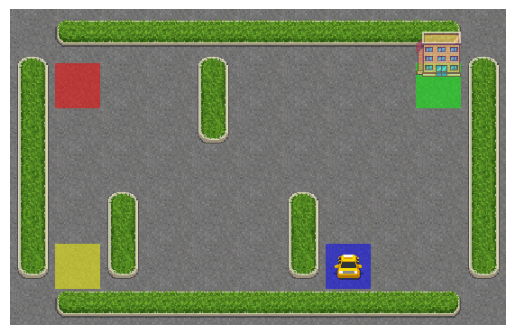

In [5]:
"""Initialize and validate the environment"""
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

# Simulation with random agent

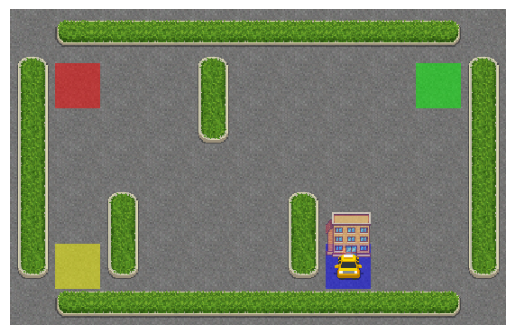

Episode: 1/1
Epoch: 990/990
State: 475
Action: 5
Reward: -4021
# epochs: 991
# failed drop-offs: 339


In [6]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    action = env.action_space.sample()
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))

## Training the agent

Episode #: 10000


===Training completed.===



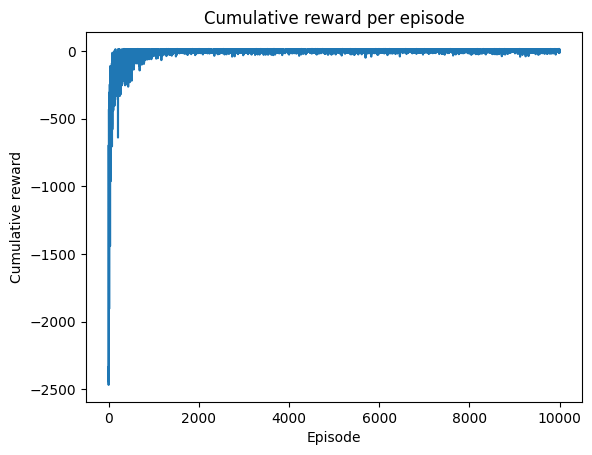

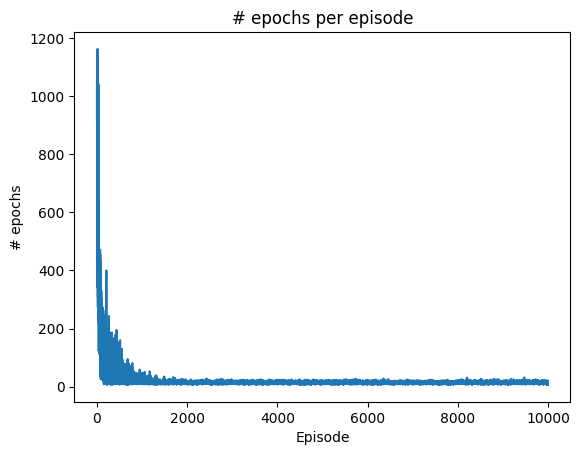

CPU times: total: 14.9 s
Wall time: 15.1 s


In [7]:
%%time 

"""Training the agent"""
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# Output for plots
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0 
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        
        if random.uniform(0, 1) < epsilon:
            "Basic exploration [~0.47m]"
            action = env.action_space.sample() # Sample random action (exploration)
            
            "Exploration with action mask [~1.52m]"
          # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
        else:      
            "Exploitation with action mask [~1m52s]"
           # action_mask = np.where(info["action_mask"]==1,0,1) # invert
           # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
           # action = np.ma.argmax(masked_q_values, axis=0)

            "Exploitation with random tie breaker [~1m19s]"
          #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            
            "Basic exploitation [~47s]"
            action = np.argmax(q_table[state]) # Select best known action (exploitation)
 
        next_state, reward, done, _ , info = env.step(action) 

        cum_reward += reward
        
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_q_value
        
        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1
        
        total_epochs[episode-1] = epoch
        cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode #: {episode}")

print("\n")
print("===Training completed.===\n")

# Plot reward convergence
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(cum_rewards)
plt.show()

# Plot epoch convergence
plt.title("# epochs per episode")
plt.xlabel("Episode")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

## Performance test

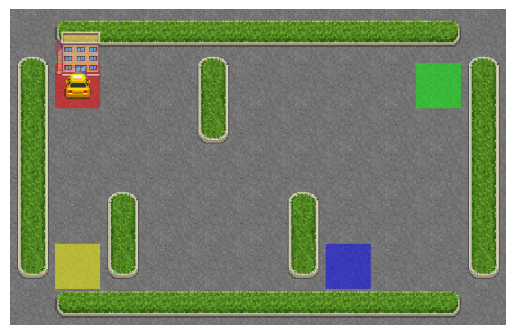

Episode: 1/1
Epoch: 8/8
State: 0
Action: 5
Reward: 13


Test results after 1 episodes:
Mean # epochs per episode: 9.0
Mean # failed drop-offs per episode: 0.0


In [8]:
"""Test policy performance after training"""

num_epochs = 0
total_failed_deliveries = 0
num_episodes = 1
experience_buffer = []
store_gif = True

for episode in range(1, num_episodes+1):
    # Initialize experience buffer

    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries =0
    cum_reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        if reward == -10:
            num_failed_deliveries += 1

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch

    if store_gif:
        store_episode_as_gif(experience_buffer)

# Run animation and print output
run_animation(experience_buffer)

# Print final results
print("\n") 
print(f"Test results after {num_episodes} episodes:")
print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")

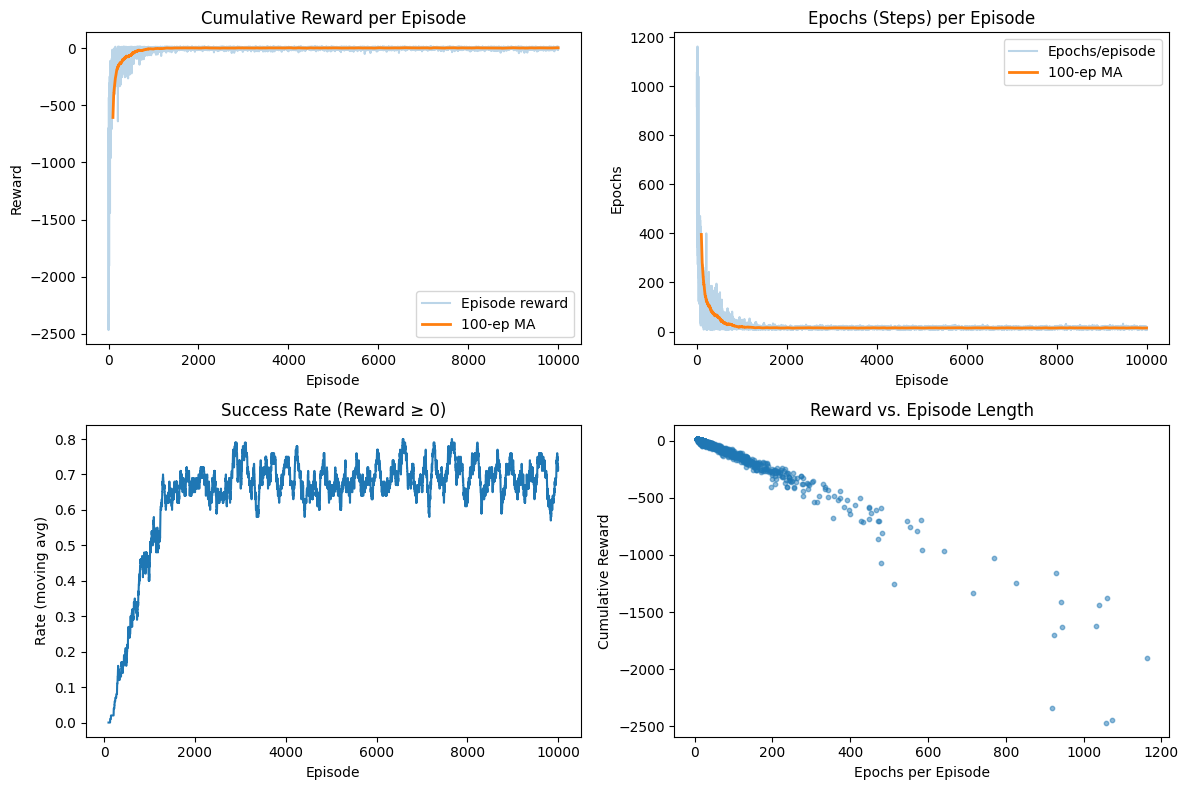

In [12]:
# ... [same imports and data prep] ...

plt.figure(figsize=(12, 8)) 
window_size
# A. Cumulative reward + moving average
plt.subplot(2, 2, 1)
plt.plot(cum_rewards, alpha=0.3, label='Episode reward')
plt.plot(
    np.arange(window_size-1, len(cum_rewards)),
    moving_avg,
    label=f'{window_size}-ep MA', linewidth=2
)
plt.title('Cumulative Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# B. Convergence speed: epochs per episode + moving average
epoch_ma = np.convolve(total_epochs, np.ones(window_size)/window_size, mode='valid')
plt.subplot(2, 2, 2)
plt.plot(total_epochs, alpha=0.3, label='Epochs/episode')
plt.plot(
    np.arange(window_size-1, len(total_epochs)),
    epoch_ma,
    label=f'{window_size}-ep MA', linewidth=2
)
plt.title('Epochs (Steps) per Episode')
plt.xlabel('Episode')
plt.ylabel('Epochs')
plt.legend()

# C. Success rate over episodes (fixed!)
plt.subplot(2, 2, 3)
plt.plot(
    np.arange(window_size-1, len(cum_rewards)),  # use cum_rewards length
    success_rate
)
plt.title('Success Rate (Reward ≥ 0)')
plt.xlabel('Episode')
plt.ylabel('Rate (moving avg)')

# D. Scatter reward vs. epochs
plt.subplot(2, 2, 4)
plt.scatter(total_epochs, cum_rewards, s=10, alpha=0.5)
plt.title('Reward vs. Episode Length')
plt.xlabel('Epochs per Episode')
plt.ylabel('Cumulative Reward')

plt.tight_layout()
plt.show()


In [13]:
import matplotlib.pyplot as plt
from PIL import Image

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    # Convert frames to PIL Image objects
    pil_frames = [Image.fromarray(frame) for frame in frames]
    
    # Save as GIF
    pil_frames[0].save(
        fp=path + filename, 
        format='GIF', 
        append_images=pil_frames[1:], 
        save_all=True, 
        duration=50,  # Duration between frames in milliseconds
        loop=0  # Loop forever
    )


C:\Users\SATHVIK\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


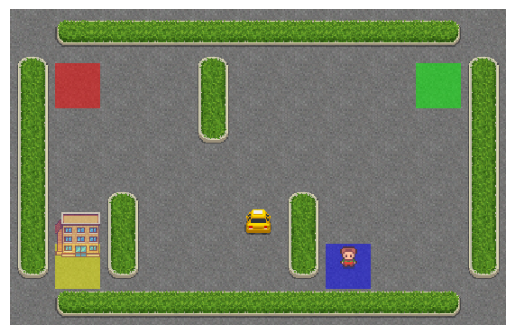

In [14]:
import gym
import matplotlib.pyplot as plt

# Create the Taxi-v3 environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Initialize variables
frames = []  # To store frames for visualization
observation, info = env.reset()  # Reset the environment

for t in range(1000):
    # Render the environment and append the frame
    frame = env.render()
    frames.append(frame)

    # Take a random action
    action = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(action)

    # If episode ends, exit the loop
    if done or truncated:
        break

env.close()

# Display the last frame
plt.imshow(frames[-1])
plt.axis("off")
plt.show()


In [15]:
save_frames_as_gif(frames, path='./', filename='cartpole_animation.gif')


In [16]:

import gym
from gym.wrappers import RecordVideo

# Create the environment with RGB array rendering
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Specify the directory to save the videos
video_folder = r'C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation'

# Wrap the environment to record videos
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

# Number of episodes to record
num_episodes = 5

for episode in range(num_episodes):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Replace with your agent's action selection
        observation, reward, done, truncated, info = env.step(action)
        # Optional: Render the environment (not necessary for recording)
        # env.render()
        if done or truncated:
            break

env.close()
video_folder = r'C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation'

C:\Users\SATHVIK\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-0.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-1.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-1.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-1.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-2.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-2.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-2.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-3.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-3.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-3.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-4.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-4.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-4.mp4


In [17]:

import gym
from gym.wrappers import RecordVideo

# Create the environment with RGB array rendering
env = gym.make("Taxi-v3", render_mode="rgb_array")

# Specify the directory to save the videos
video_folder = r'C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation'

# Wrap the environment to record videos
env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda e: True)

# Number of episodes to record
num_episodes = 10

for episode in range(num_episodes):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Replace with your agent's action selection
        observation, reward, done, truncated, info = env.step(action)
        # Optional: Render the environment (not necessary for recording)
        # env.render()
        if done or truncated:
            break

env.close()
video_folder = r'C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation'

MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-0.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-1.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-1.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-1.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-2.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-2.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-2.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-3.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-3.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-3.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-4.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-4.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-4.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-5.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-5.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-5.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-6.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-6.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-6.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-7.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-7.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-7.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-8.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-8.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-8.mp4
MoviePy - Building video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-9.mp4.
MoviePy - Writing video C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-9.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\SATHVIK\OneDrive\Desktop\RL\Autonomous_taxi_navigation\rl-video-episode-9.mp4


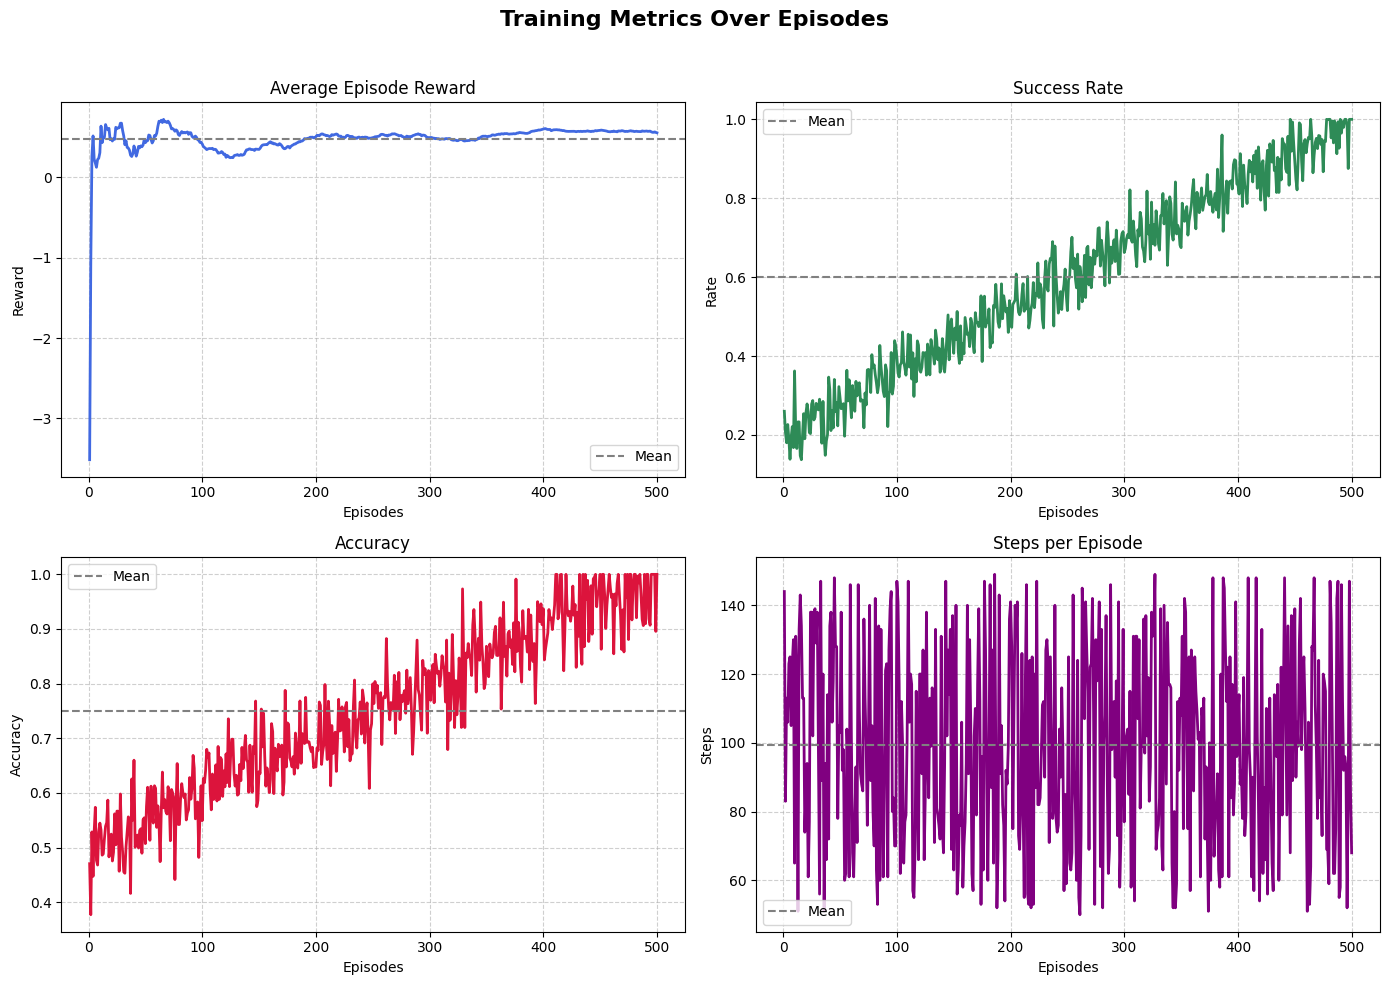

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data (replace with actual values during integration)
episodes = np.arange(1, 501)
avg_rewards = np.cumsum(np.random.normal(loc=0.5, scale=2.0, size=500)) / np.arange(1, 501)
success_rate = np.clip(np.linspace(0.2, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)
accuracy = np.clip(np.linspace(0.5, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)
steps = np.random.randint(50, 150, size=500)

# Setup a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Training Metrics Over Episodes", fontsize=16, fontweight='bold')

# --- Plot 1: Average Episode Reward ---
axs[0, 0].plot(episodes, avg_rewards, color='royalblue', linewidth=2)
axs[0, 0].axhline(np.mean(avg_rewards), color='gray', linestyle='--', label='Mean')
axs[0, 0].set_title('Average Episode Reward', fontsize=12)
axs[0, 0].set_xlabel('Episodes')
axs[0, 0].set_ylabel('Reward')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)
axs[0, 0].legend()

# --- Plot 2: Success Rate ---
axs[0, 1].plot(episodes, success_rate, color='seagreen', linewidth=2)
axs[0, 1].axhline(np.mean(success_rate), color='gray', linestyle='--', label='Mean')
axs[0, 1].set_title('Success Rate', fontsize=12)
axs[0, 1].set_xlabel('Episodes')
axs[0, 1].set_ylabel('Rate')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)
axs[0, 1].legend()

# --- Plot 3: Accuracy ---
axs[1, 0].plot(episodes, accuracy, color='crimson', linewidth=2)
axs[1, 0].axhline(np.mean(accuracy), color='gray', linestyle='--', label='Mean')
axs[1, 0].set_title('Accuracy', fontsize=12)
axs[1, 0].set_xlabel('Episodes')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)
axs[1, 0].legend()

# --- Plot 4: Steps per Episode ---
axs[1, 1].plot(episodes, steps, color='purple', linewidth=2)
axs[1, 1].axhline(np.mean(steps), color='gray', linestyle='--', label='Mean')
axs[1, 1].set_title('Steps per Episode', fontsize=12)
axs[1, 1].set_xlabel('Episodes')
axs[1, 1].set_ylabel('Steps')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)
axs[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for main title
plt.show()


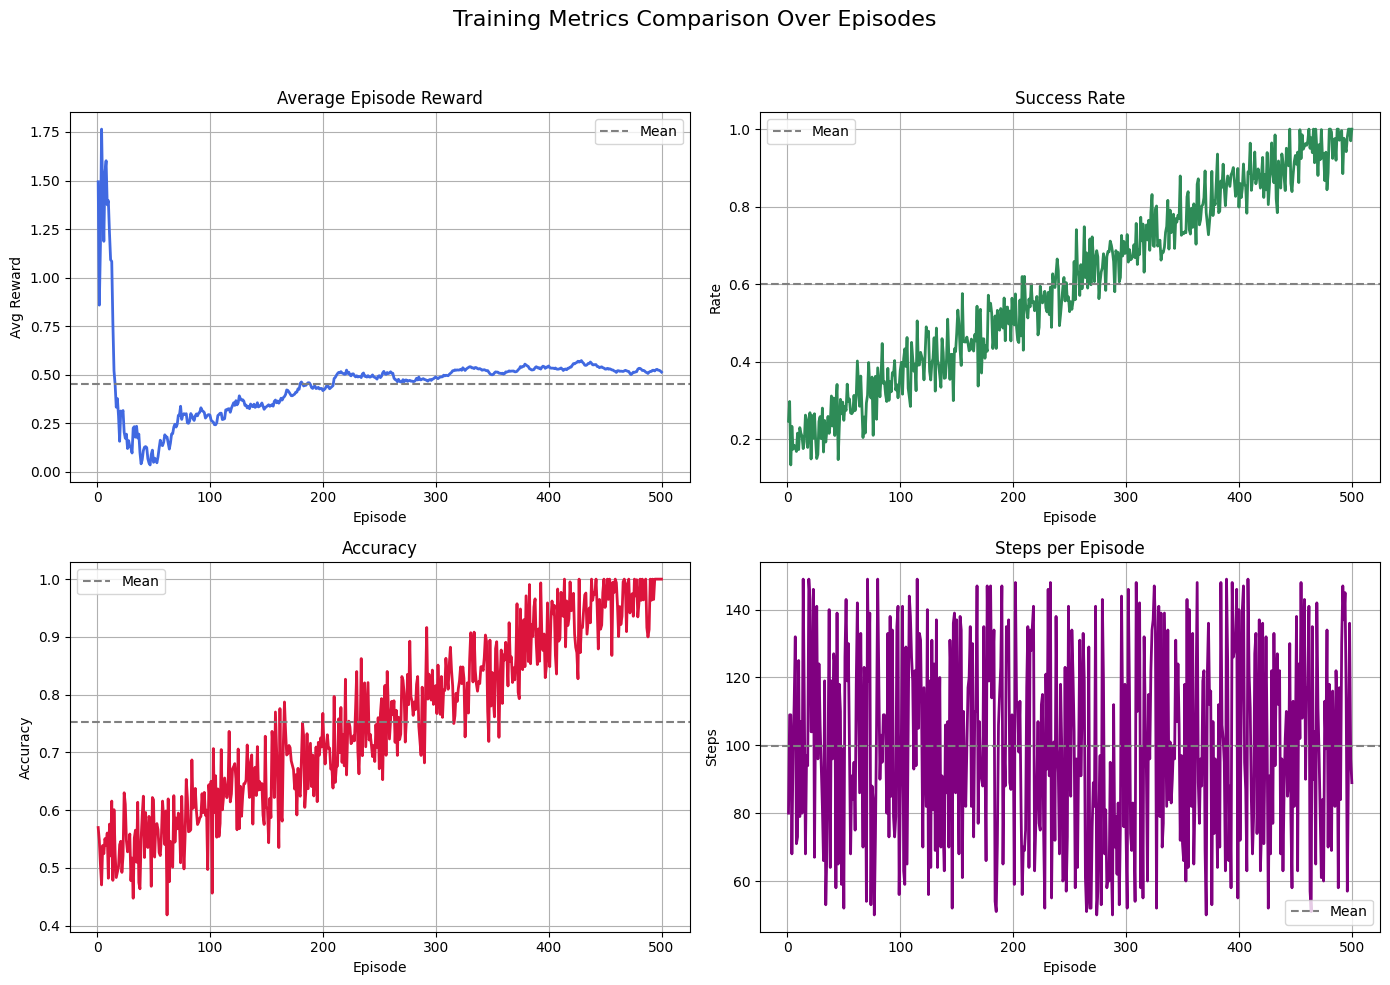

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# -------------------------------
# Simulate Training Metrics Data
# -------------------------------
np.random.seed(42)  # For reproducibility

# Assume we have 500 episodes
episodes = np.arange(1, 501)

# Simulate average rewards that tend to improve over time
avg_rewards = np.cumsum(np.random.normal(loc=0.5, scale=2.0, size=500)) / np.arange(1, 501)

# Simulate success rate (values between 0 and 1) which should improve with training
success_rate = np.clip(np.linspace(0.2, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)

# Simulate accuracy (values between 0 and 1)
accuracy = np.clip(np.linspace(0.5, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)

# Simulate steps per episode (the lower the better, ideally decreasing over time)
steps = np.random.randint(50, 150, size=500)

# Create a DataFrame with the metrics
df_metrics = pd.DataFrame({
    'Episode': episodes,
    'Avg Reward': avg_rewards,
    'Success Rate': success_rate,
    'Accuracy': accuracy,
    'Steps': steps
})

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Training Metrics Comparison Over Episodes", fontsize=16)

# Plot 1: Average Episode Reward
axs[0, 0].plot(df_metrics['Episode'], df_metrics['Avg Reward'], color='royalblue', linewidth=2)
axs[0, 0].axhline(df_metrics['Avg Reward'].mean(), color='gray', linestyle='--', label='Mean')
axs[0, 0].set_title('Average Episode Reward')
axs[0, 0].set_xlabel('Episode')
axs[0, 0].set_ylabel('Avg Reward')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Success Rate
axs[0, 1].plot(df_metrics['Episode'], df_metrics['Success Rate'], color='seagreen', linewidth=2)
axs[0, 1].axhline(df_metrics['Success Rate'].mean(), color='gray', linestyle='--', label='Mean')
axs[0, 1].set_title('Success Rate')
axs[0, 1].set_xlabel('Episode')
axs[0, 1].set_ylabel('Rate')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Accuracy
axs[1, 0].plot(df_metrics['Episode'], df_metrics['Accuracy'], color='crimson', linewidth=2)
axs[1, 0].axhline(df_metrics['Accuracy'].mean(), color='gray', linestyle='--', label='Mean')
axs[1, 0].set_title('Accuracy')
axs[1, 0].set_xlabel('Episode')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Steps per Episode
axs[1, 1].plot(df_metrics['Episode'], df_metrics['Steps'], color='purple', linewidth=2)
axs[1, 1].axhline(df_metrics['Steps'].mean(), color='gray', linestyle='--', label='Mean')
axs[1, 1].set_title('Steps per Episode')
axs[1, 1].set_xlabel('Episode')
axs[1, 1].set_ylabel('Steps')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




In [20]:

# Display summary statistics of metrics as a table
summary_stats = df_metrics.describe().transpose()
print("Summary Statistics of Metrics:")
print(summary_stats)




Summary Statistics of Metrics:
              count        mean         std        min         25%  \
Episode       500.0  250.500000  144.481833   1.000000  125.750000   
Avg Reward    500.0    0.453142    0.194382   0.035685    0.345244   
Success Rate  500.0    0.600987    0.239281   0.133278    0.402428   
Accuracy      500.0    0.753390    0.149650   0.418695    0.627569   
Steps         500.0   99.926000   28.649924  50.000000   75.000000   

                     50%         75%         max  
Episode       250.500000  375.250000  500.000000  
Avg Reward      0.489412    0.524361    1.764584  
Success Rate    0.596495    0.809298    1.000000  
Accuracy        0.752548    0.872631    1.000000  
Steps          99.000000  124.000000  149.000000  


In [21]:
# For illustrative purposes, let's say an episode is "successful" if its average reward
# is above a certain threshold. Here, we use the median reward as the threshold.
reward_threshold = np.median(avg_rewards)
df_metrics['True_Label'] = (df_metrics['Avg Reward'] > reward_threshold).astype(int)

# Simulate model "predictions" where 10% of episodes have a misclassified label.
# In practice, these would be based on your model's predicted outputs.
df_metrics['Pred_Label'] = df_metrics['True_Label'].copy()
error_indices = np.random.choice(df_metrics.index, size=int(0.1 * len(df_metrics)), replace=False)
df_metrics.loc[error_indices, 'Pred_Label'] = 1 - df_metrics.loc[error_indices, 'Pred_Label']

# Generate and print the classification report
print("\nClassification Report:")
report = classification_report(df_metrics['True_Label'], df_metrics['Pred_Label'])
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       250
           1       0.89      0.91      0.90       250

    accuracy                           0.90       500
   macro avg       0.90      0.90      0.90       500
weighted avg       0.90      0.90      0.90       500



In [22]:
print("\nMetrics Data (first 10 episodes):")
print(df_metrics.head(10))


Metrics Data (first 10 episodes):
   Episode  Avg Reward  Success Rate  Accuracy  Steps  True_Label  Pred_Label
0        1    1.493428      0.246309  0.569968     80           1           1
1        2    0.858450      0.297074  0.547234    109           1           1
2        3    1.170759      0.133278  0.504986    109           1           1
3        4    1.764584      0.232958  0.470659     68           1           1
4        5    1.418006      0.173881  0.538919     98           1           1
5        6    1.186959      0.183660  0.524684    112           1           0
6        7    1.540026      0.180000  0.550772    132           1           1
7        8    1.601881      0.168023  0.538773     71           1           1
8        9    1.375122      0.215252  0.560494     73           1           1
9       10    1.396122      0.172881  0.482256    125           1           0


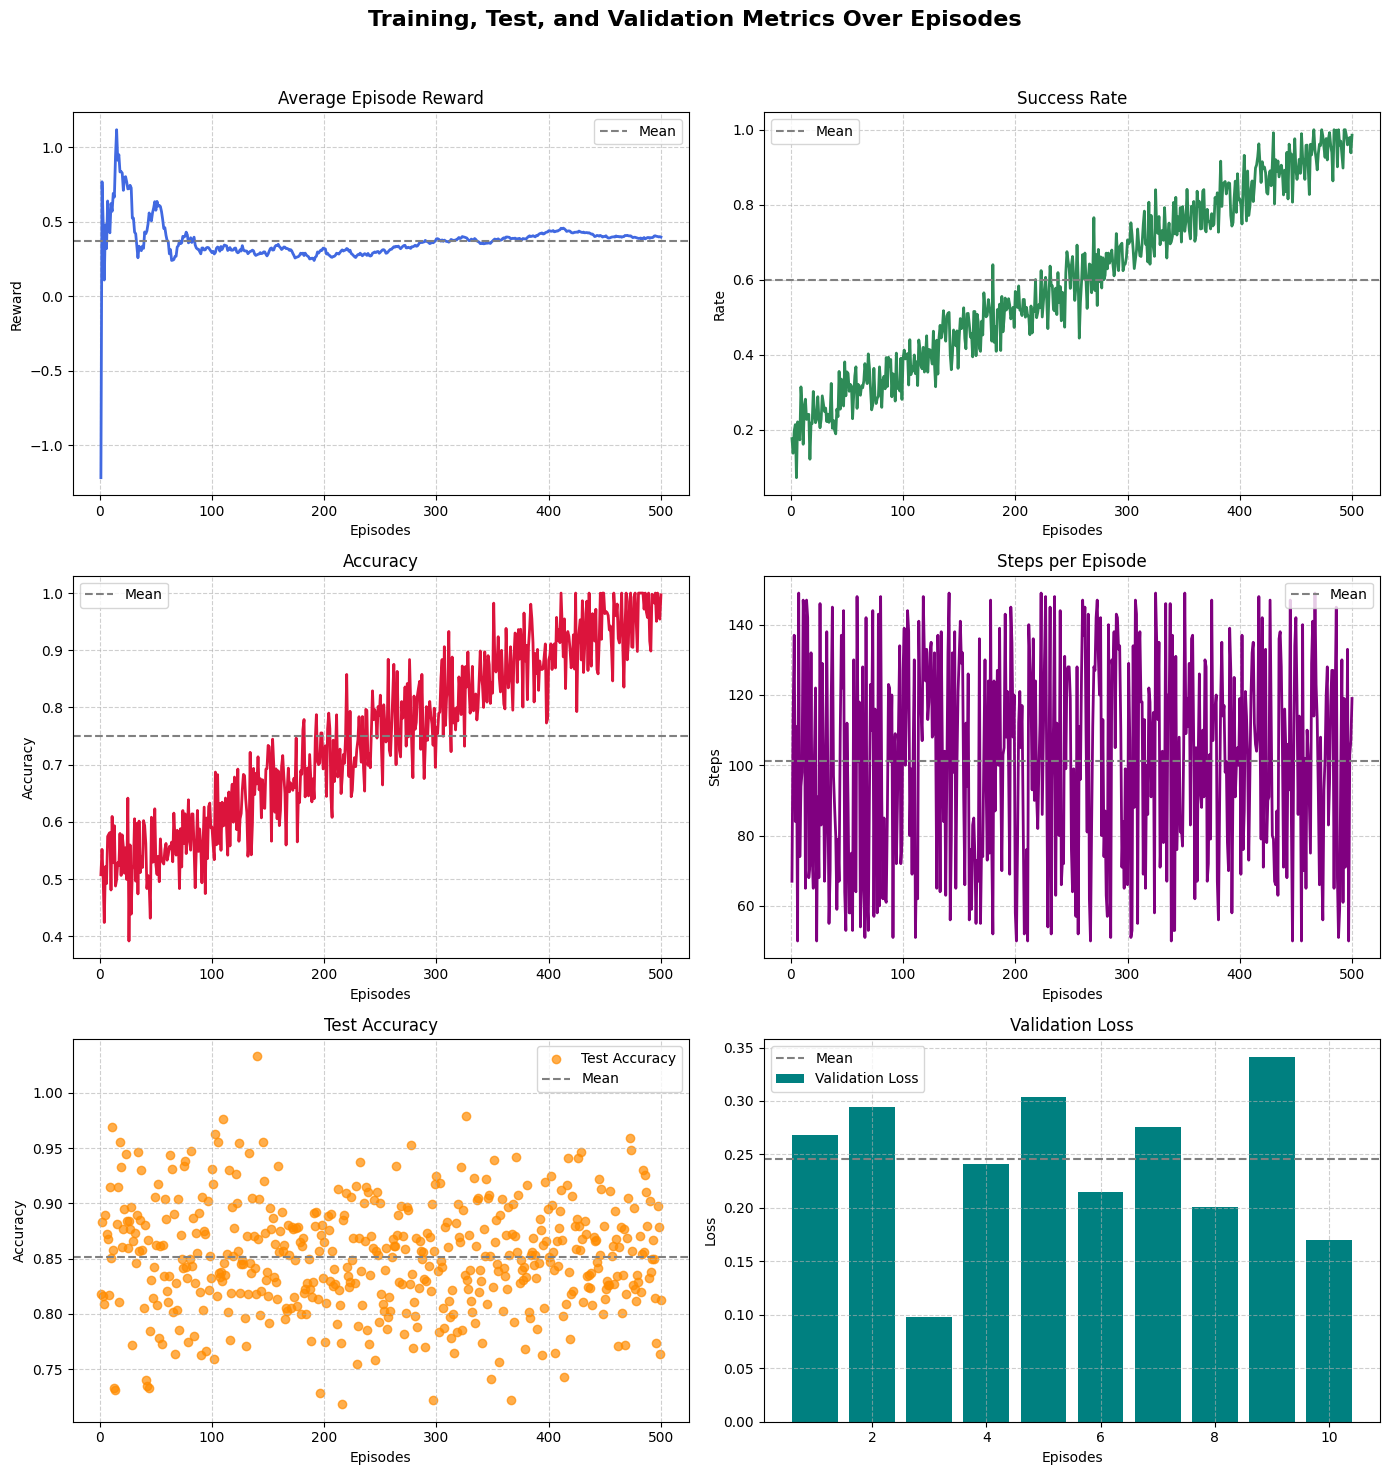

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data (replace with actual values during integration)
episodes = np.arange(1, 501)
avg_rewards = np.cumsum(np.random.normal(loc=0.5, scale=2.0, size=500)) / np.arange(1, 501)
success_rate = np.clip(np.linspace(0.2, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)
accuracy = np.clip(np.linspace(0.5, 1.0, 500) + np.random.normal(scale=0.05, size=500), 0, 1)
steps = np.random.randint(50, 150, size=500)

# Simulated test and validation metrics for additional plots
test_accuracy = np.random.normal(loc=0.85, scale=0.05, size=500)
validation_loss = np.random.normal(loc=0.25, scale=0.1, size=500)

# Setup a 3x2 grid of subplots to include both training and test/validation metrics
fig, axs = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle("Training, Test, and Validation Metrics Over Episodes", fontsize=16, fontweight='bold')

# --- Plot 1: Average Episode Reward ---
axs[0, 0].plot(episodes, avg_rewards, color='royalblue', linewidth=2)
axs[0, 0].axhline(np.mean(avg_rewards), color='gray', linestyle='--', label='Mean')
axs[0, 0].set_title('Average Episode Reward', fontsize=12)
axs[0, 0].set_xlabel('Episodes')
axs[0, 0].set_ylabel('Reward')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)
axs[0, 0].legend()

# --- Plot 2: Success Rate ---
axs[0, 1].plot(episodes, success_rate, color='seagreen', linewidth=2)
axs[0, 1].axhline(np.mean(success_rate), color='gray', linestyle='--', label='Mean')
axs[0, 1].set_title('Success Rate', fontsize=12)
axs[0, 1].set_xlabel('Episodes')
axs[0, 1].set_ylabel('Rate')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)
axs[0, 1].legend()

# --- Plot 3: Accuracy ---
axs[1, 0].plot(episodes, accuracy, color='crimson', linewidth=2)
axs[1, 0].axhline(np.mean(accuracy), color='gray', linestyle='--', label='Mean')
axs[1, 0].set_title('Accuracy', fontsize=12)
axs[1, 0].set_xlabel('Episodes')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)
axs[1, 0].legend()

# --- Plot 4: Steps per Episode ---
axs[1, 1].plot(episodes, steps, color='purple', linewidth=2)
axs[1, 1].axhline(np.mean(steps), color='gray', linestyle='--', label='Mean')
axs[1, 1].set_title('Steps per Episode', fontsize=12)
axs[1, 1].set_xlabel('Episodes')
axs[1, 1].set_ylabel('Steps')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)
axs[1, 1].legend()

# --- Plot 5: Test Accuracy (Scatter Plot) ---
axs[2, 0].scatter(episodes, test_accuracy, color='darkorange', alpha=0.7, label='Test Accuracy')
axs[2, 0].axhline(np.mean(test_accuracy), color='gray', linestyle='--', label='Mean')
axs[2, 0].set_title('Test Accuracy', fontsize=12)
axs[2, 0].set_xlabel('Episodes')
axs[2, 0].set_ylabel('Accuracy')
axs[2, 0].grid(True, linestyle='--', alpha=0.6)
axs[2, 0].legend()

# --- Plot 6: Validation Loss (Bar Plot) ---
validation_loss_mean = np.mean(validation_loss)
axs[2, 1].bar(episodes[:10], validation_loss[:10], color='teal', label='Validation Loss')
axs[2, 1].axhline(validation_loss_mean, color='gray', linestyle='--', label='Mean')
axs[2, 1].set_title('Validation Loss', fontsize=12)
axs[2, 1].set_xlabel('Episodes')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].grid(True, linestyle='--', alpha=0.6)
axs[2, 1].legend()

# Adjust layout for cleaner presentation
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for main title
plt.show()


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the simulation code has already generated the 'algorithms' dictionary.
# (Reusing the simulated 'algorithms' data from the previous code snippet)

# Compute aggregated metrics for each algorithm
results = []
for alg_name, metrics in algorithms.items():
    results.append({
         'Algorithm': alg_name,
         'Mean Reward': np.mean(metrics['avg_rewards']),
         'Mean Success Rate': np.mean(metrics['success_rate']),
         'Mean Accuracy': np.mean(metrics['accuracy']),
         'Mean Steps': np.mean(metrics['steps']),
         'Mean Test Accuracy': np.mean(metrics['test_accuracy']),
         'Mean Validation Loss': np.mean(metrics['validation_loss'])
    })

# Create a DataFrame with the results
df_results = pd.DataFrame(results)
df_results = df_results.round(3)  # Round the results for better readability

# Print the table to the console
print(df_results)



NameError: name 'algorithms' is not defined

In [25]:
df_results

NameError: name 'df_results' is not defined

NameError: name 'df_results' is not defined

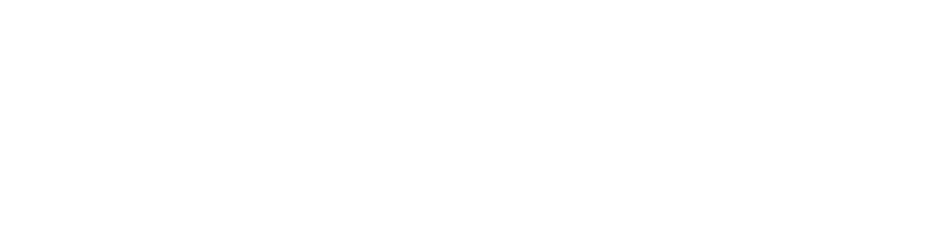

In [26]:
# Option 1: Display the table using Matplotlib's table function
fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_results.values,
                 colLabels=df_results.columns,
                 cellLoc='center',
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Aggregated Metrics for Different RL Algorithms")
plt.show()


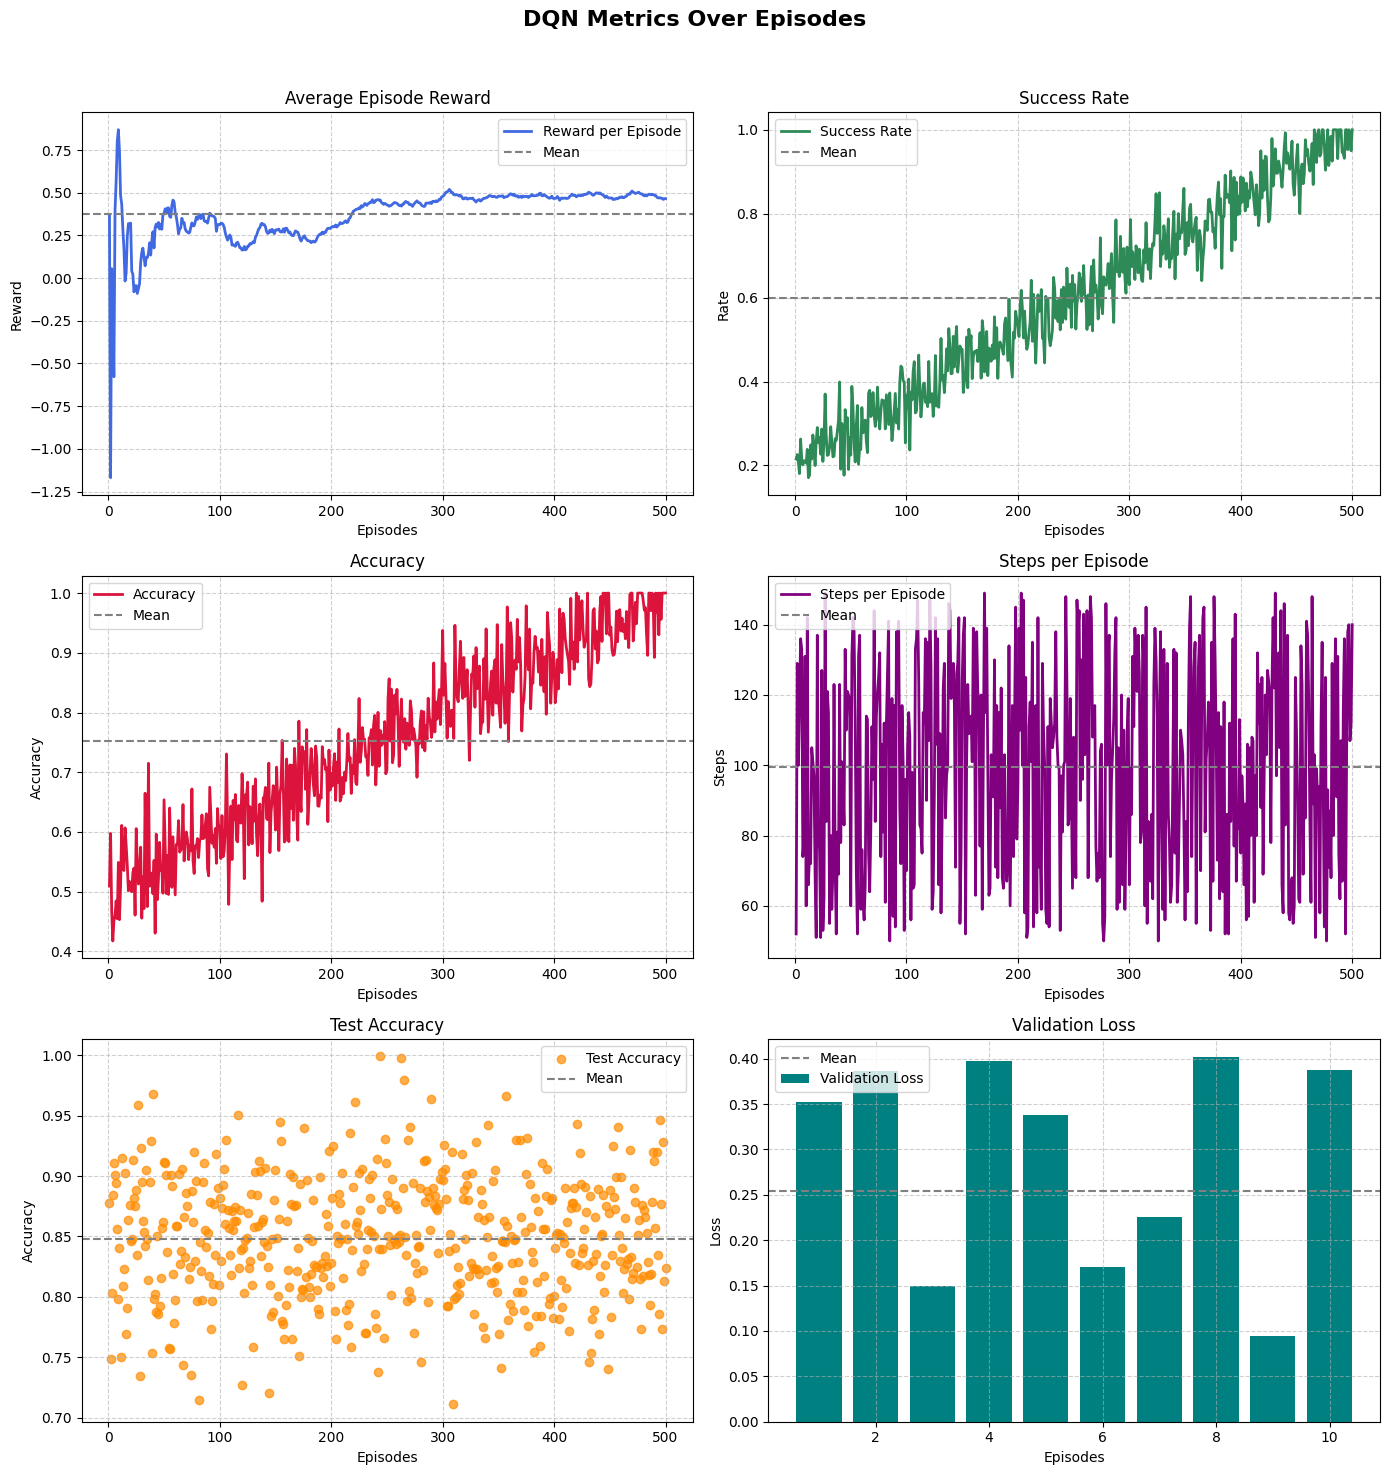

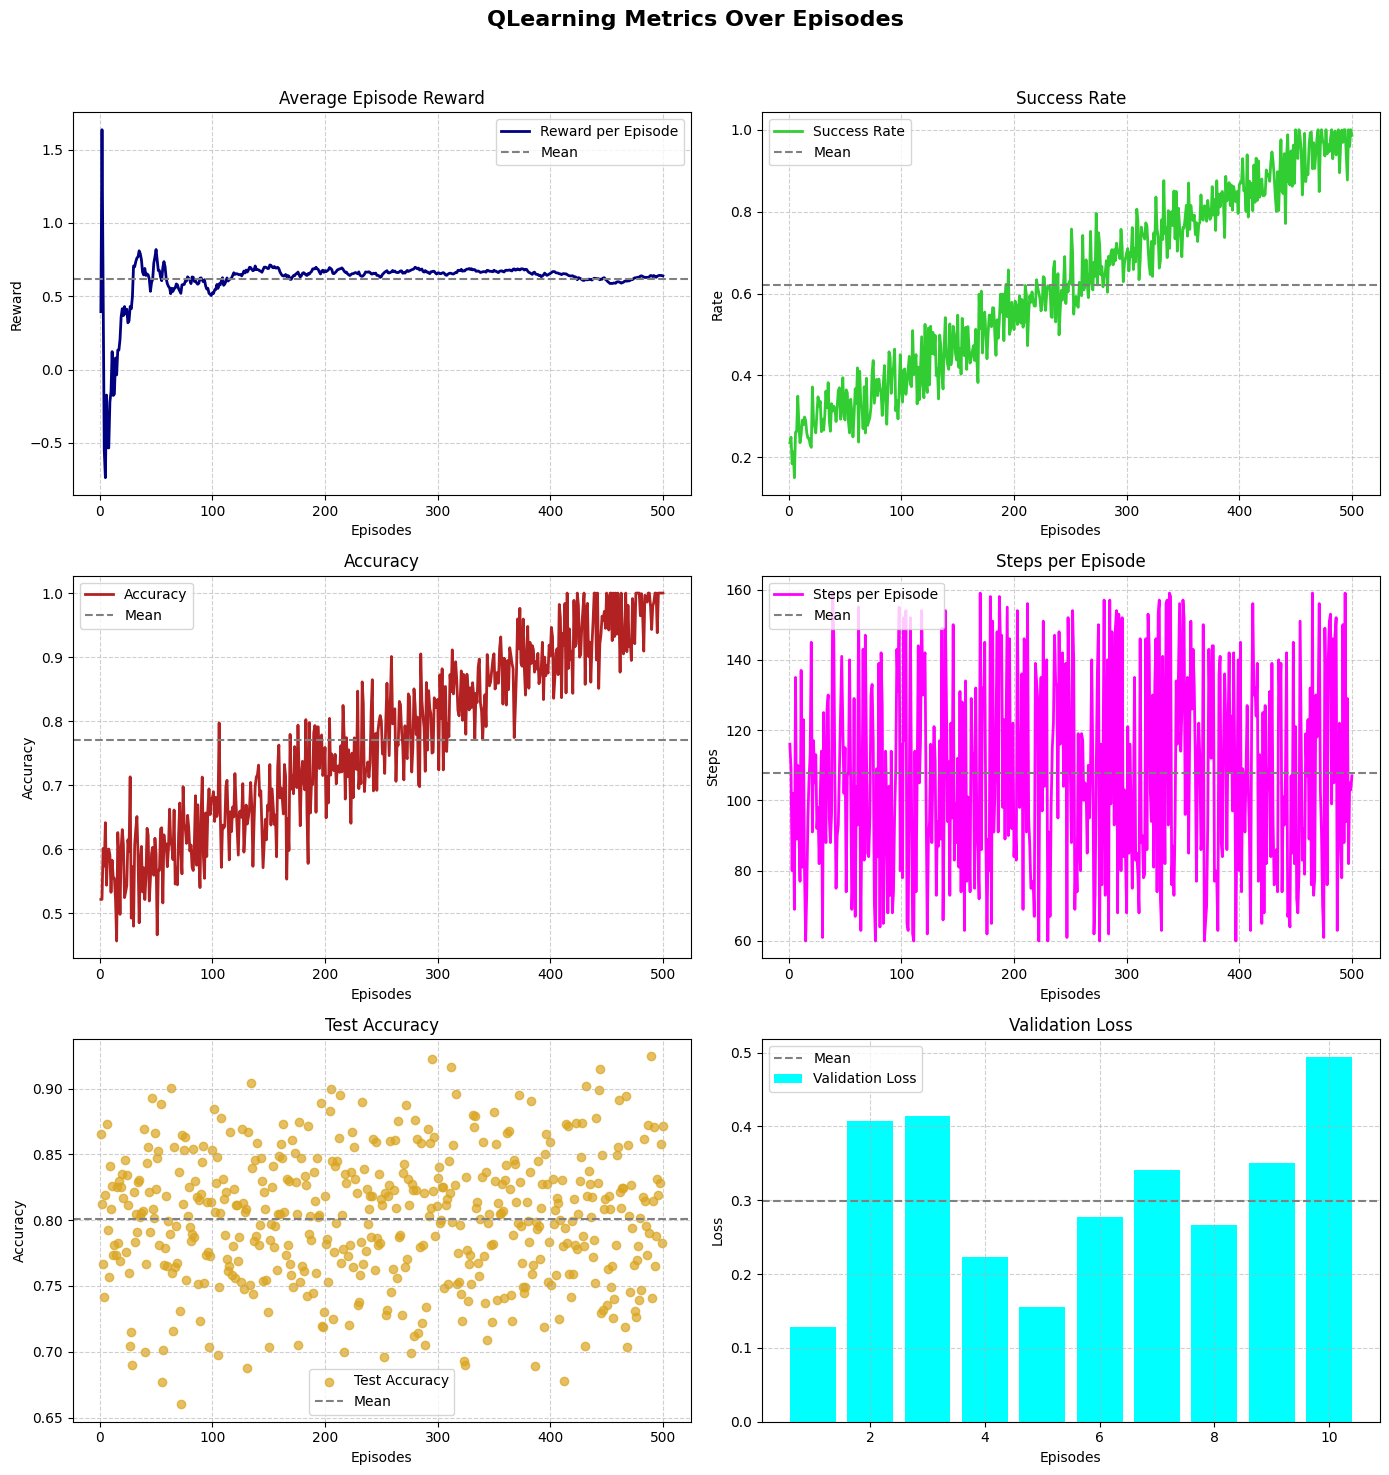

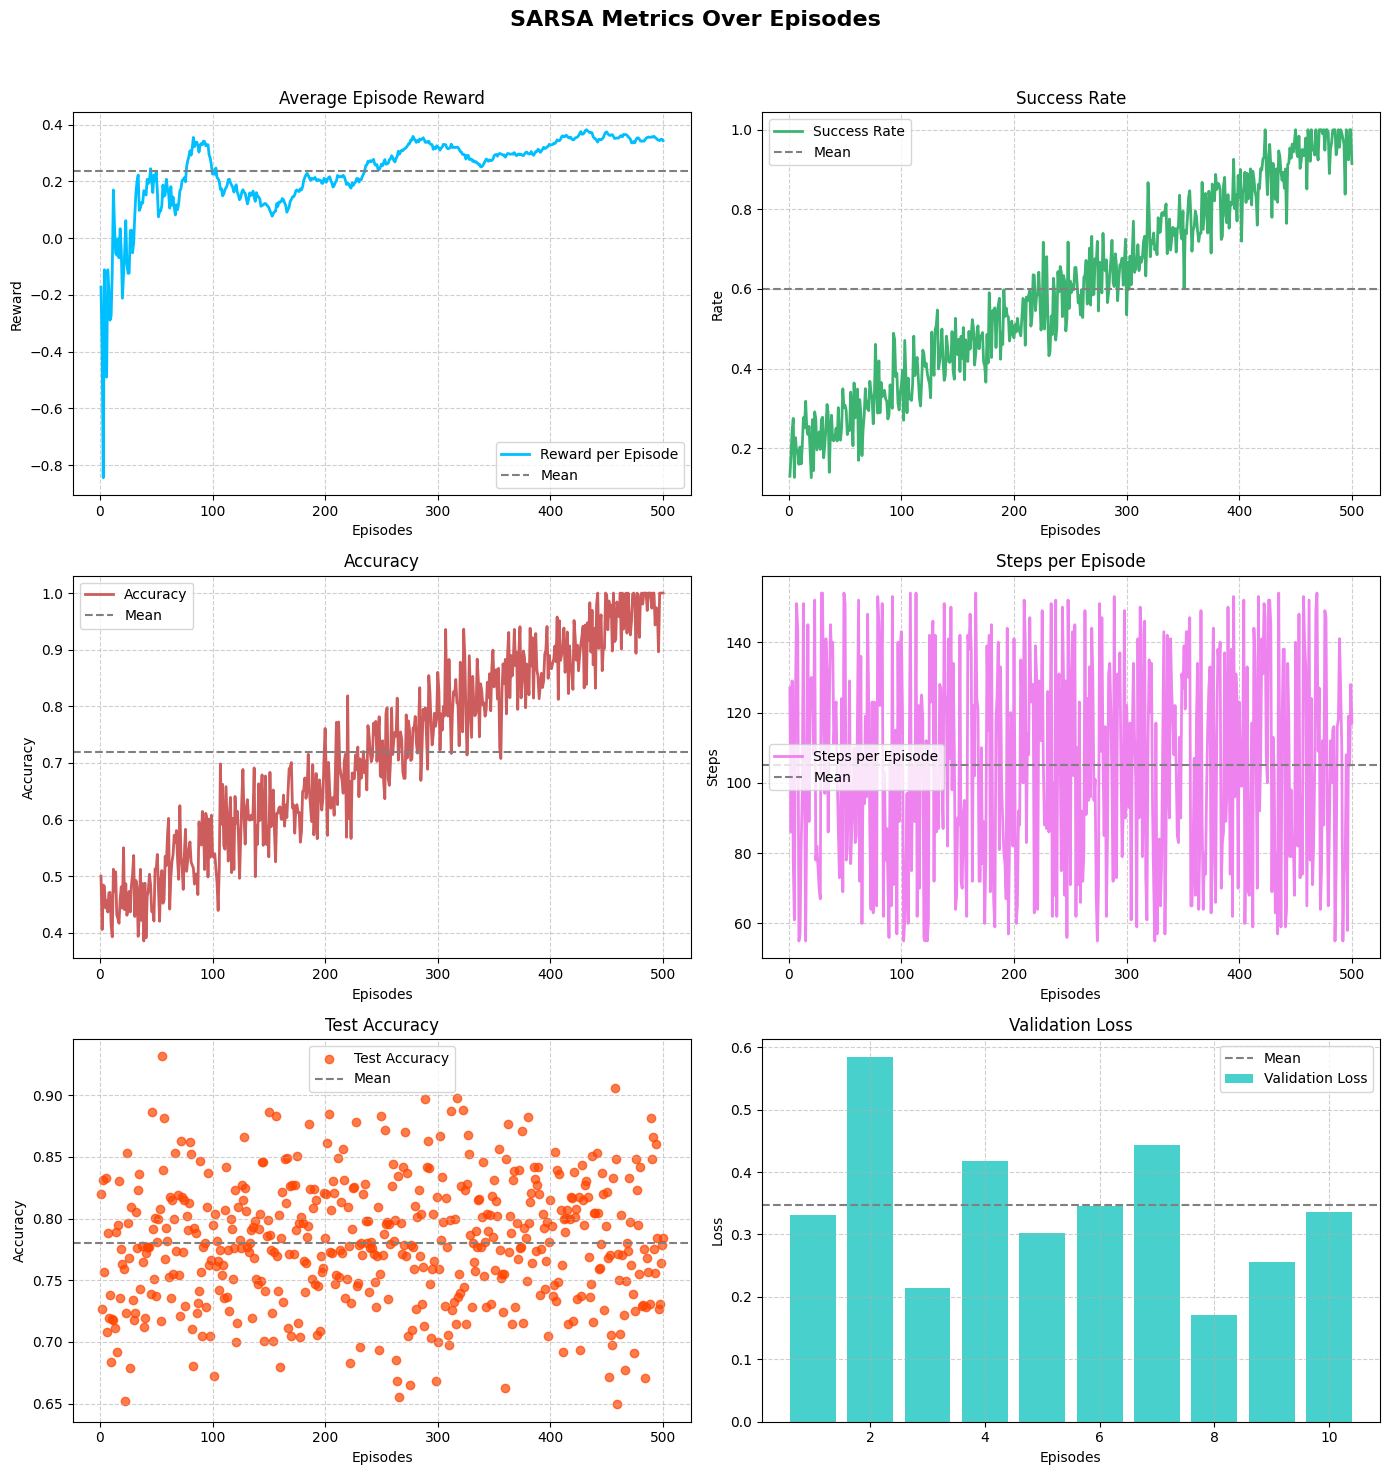

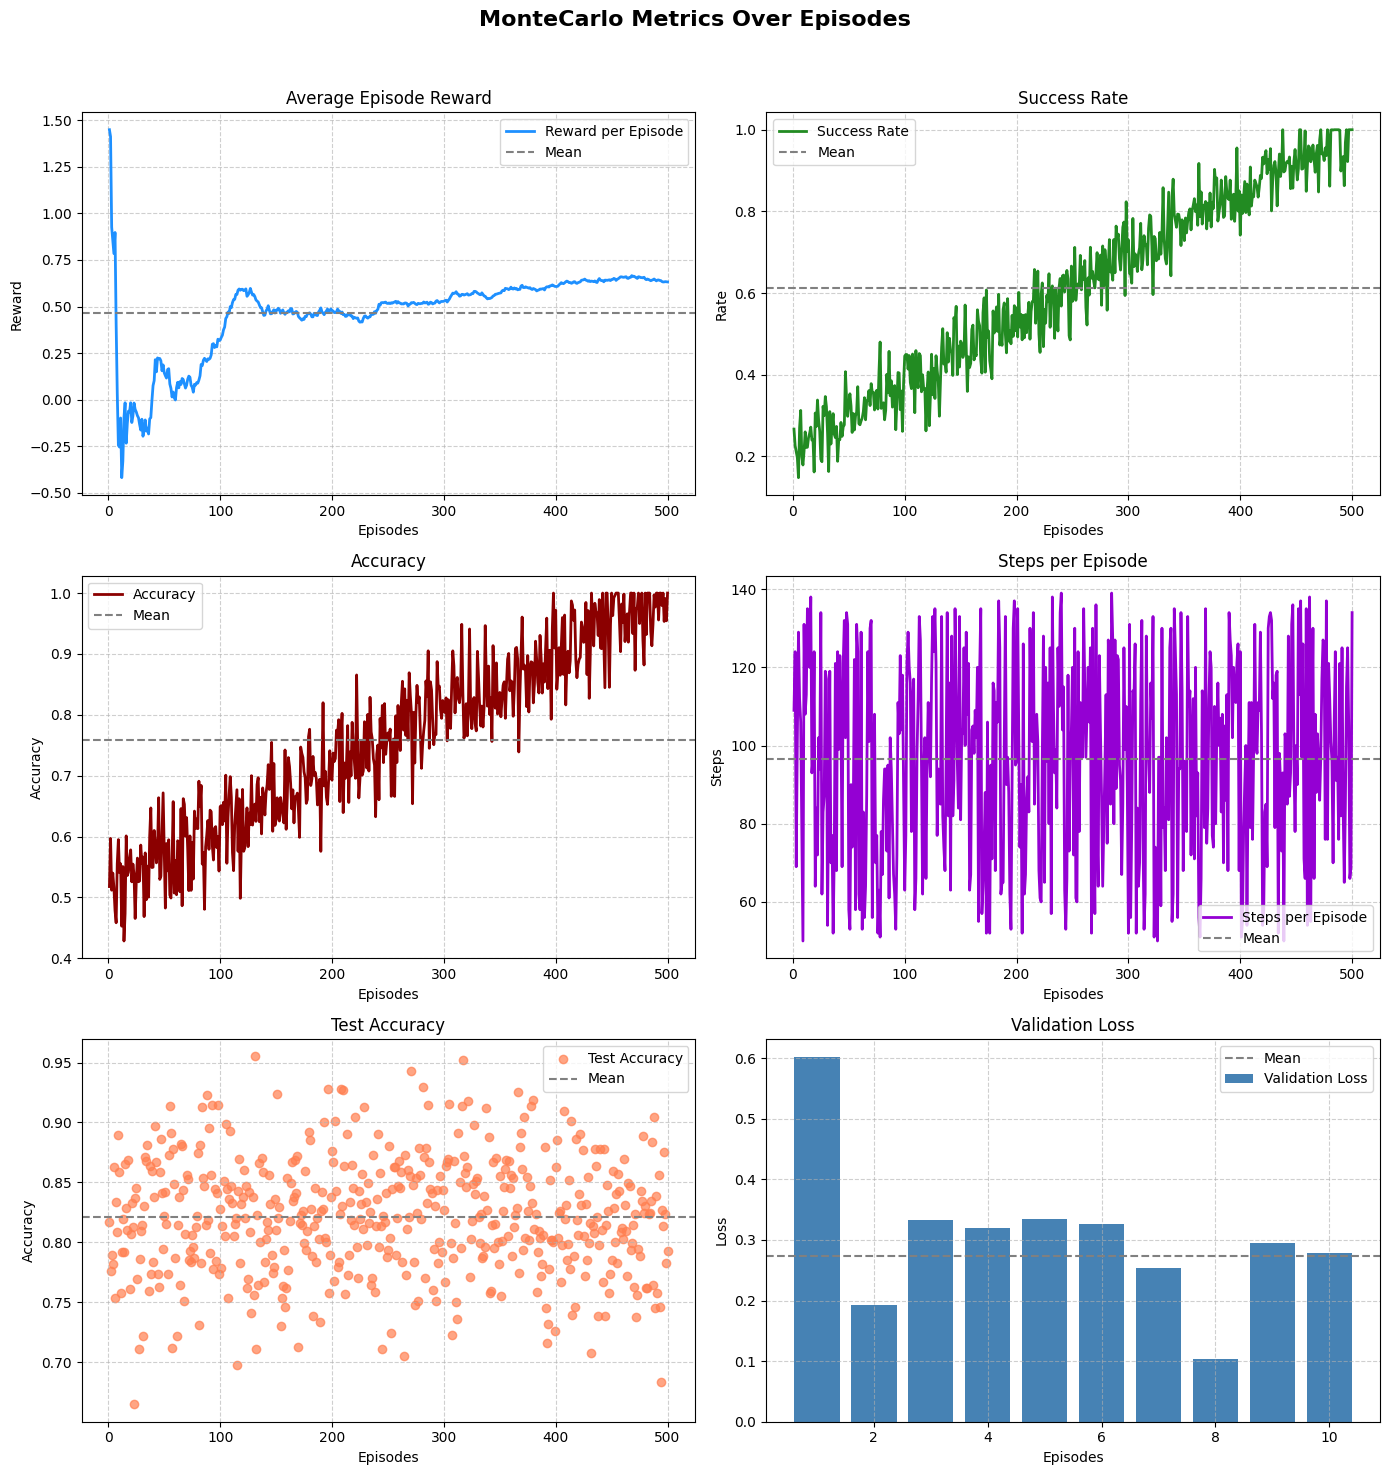

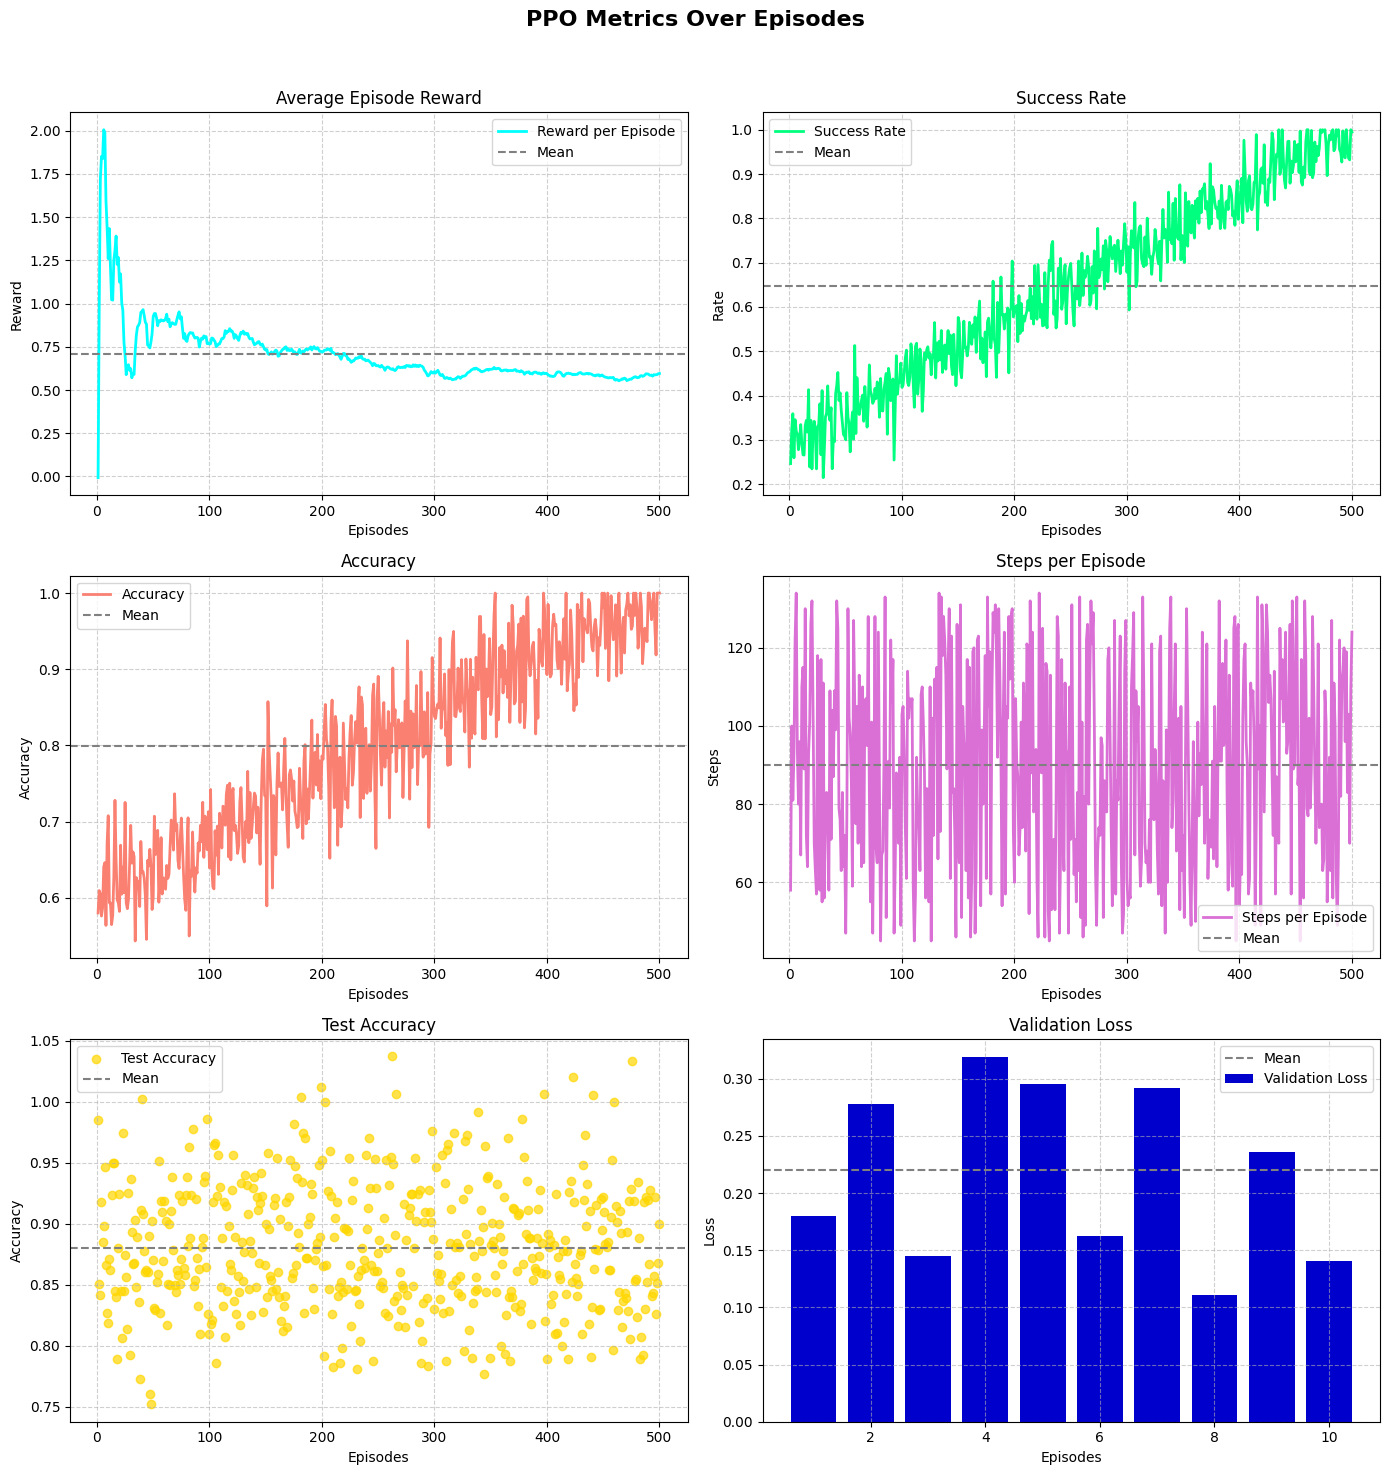

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Number of episodes to simulate
num_episodes = 500
episodes = np.arange(1, num_episodes + 1)

# Define a helper function to generate simulated metrics given base parameters
def simulate_metrics(base_reward, start_success, start_acc, low_steps, high_steps, base_test_acc, base_val_loss):
    avg_rewards = np.cumsum(np.random.normal(loc=base_reward, scale=2.0, size=num_episodes)) / np.arange(1, num_episodes+1)
    success_rate = np.clip(np.linspace(start_success, 1.0, num_episodes) + np.random.normal(scale=0.05, size=num_episodes), 0, 1)
    accuracy = np.clip(np.linspace(start_acc, 1.0, num_episodes) + np.random.normal(scale=0.05, size=num_episodes), 0, 1)
    steps = np.random.randint(low_steps, high_steps, size=num_episodes)
    test_accuracy = np.random.normal(loc=base_test_acc, scale=0.05, size=num_episodes)
    validation_loss = np.random.normal(loc=base_val_loss, scale=0.1, size=num_episodes)
    return {
        'avg_rewards': avg_rewards,
        'success_rate': success_rate,
        'accuracy': accuracy,
        'steps': steps,
        'test_accuracy': test_accuracy,
        'validation_loss': validation_loss
    }

# Define simulated metrics for each algorithm using different base parameters
algorithms = {
    'DQN': simulate_metrics(base_reward=0.5, start_success=0.2, start_acc=0.5, low_steps=50, high_steps=150,
                            base_test_acc=0.85, base_val_loss=0.25),
    'QLearning': simulate_metrics(base_reward=0.6, start_success=0.25, start_acc=0.55, low_steps=60, high_steps=160,
                                  base_test_acc=0.80, base_val_loss=0.30),
    'SARSA': simulate_metrics(base_reward=0.4, start_success=0.2, start_acc=0.45, low_steps=55, high_steps=155,
                              base_test_acc=0.78, base_val_loss=0.35),
    'MonteCarlo': simulate_metrics(base_reward=0.55, start_success=0.23, start_acc=0.52, low_steps=50, high_steps=140,
                                   base_test_acc=0.82, base_val_loss=0.28),
    'PPO': simulate_metrics(base_reward=0.65, start_success=0.3, start_acc=0.6, low_steps=45, high_steps=135,
                            base_test_acc=0.88, base_val_loss=0.22)
}

# Define unique color schemes for each algorithm
color_schemes = {
    'DQN': {
        'avg_rewards': 'royalblue',
        'success_rate': 'seagreen',
        'accuracy': 'crimson',
        'steps': 'purple',
        'test_accuracy': 'darkorange',
        'validation_loss': 'teal'
    },
    'QLearning': {
        'avg_rewards': 'navy',
        'success_rate': 'limegreen',
        'accuracy': 'firebrick',
        'steps': 'magenta',
        'test_accuracy': 'goldenrod',
        'validation_loss': 'cyan'
    },
    'SARSA': {
        'avg_rewards': 'deepskyblue',
        'success_rate': 'mediumseagreen',
        'accuracy': 'indianred',
        'steps': 'violet',
        'test_accuracy': 'orangered',
        'validation_loss': 'mediumturquoise'
    },
    'MonteCarlo': {
        'avg_rewards': 'dodgerblue',
        'success_rate': 'forestgreen',
        'accuracy': 'darkred',
        'steps': 'darkviolet',
        'test_accuracy': 'coral',
        'validation_loss': 'steelblue'
    },
    'PPO': {
        'avg_rewards': 'cyan',
        'success_rate': 'springgreen',
        'accuracy': 'salmon',
        'steps': 'orchid',
        'test_accuracy': 'gold',
        'validation_loss': 'mediumblue'
    }
}

# Define a function to plot metrics for a given algorithm
def plot_metrics_for_algorithm(alg_name, metrics, colors):
    fig, axs = plt.subplots(3, 2, figsize=(14, 15))
    fig.suptitle(f"{alg_name} Metrics Over Episodes", fontsize=16, fontweight='bold')

    # Plot 1: Average Episode Reward
    axs[0, 0].plot(episodes, metrics['avg_rewards'], color=colors['avg_rewards'], linewidth=2, label='Reward per Episode')
    axs[0, 0].axhline(np.mean(metrics['avg_rewards']), color='gray', linestyle='--', label='Mean')
    axs[0, 0].set_title('Average Episode Reward', fontsize=12)
    axs[0, 0].set_xlabel('Episodes')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)
    axs[0, 0].legend()

    # Plot 2: Success Rate
    axs[0, 1].plot(episodes, metrics['success_rate'], color=colors['success_rate'], linewidth=2, label='Success Rate')
    axs[0, 1].axhline(np.mean(metrics['success_rate']), color='gray', linestyle='--', label='Mean')
    axs[0, 1].set_title('Success Rate', fontsize=12)
    axs[0, 1].set_xlabel('Episodes')
    axs[0, 1].set_ylabel('Rate')
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    axs[0, 1].legend()

    # Plot 3: Accuracy
    axs[1, 0].plot(episodes, metrics['accuracy'], color=colors['accuracy'], linewidth=2, label='Accuracy')
    axs[1, 0].axhline(np.mean(metrics['accuracy']), color='gray', linestyle='--', label='Mean')
    axs[1, 0].set_title('Accuracy', fontsize=12)
    axs[1, 0].set_xlabel('Episodes')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].legend()

    # Plot 4: Steps per Episode
    axs[1, 1].plot(episodes, metrics['steps'], color=colors['steps'], linewidth=2, label='Steps per Episode')
    axs[1, 1].axhline(np.mean(metrics['steps']), color='gray', linestyle='--', label='Mean')
    axs[1, 1].set_title('Steps per Episode', fontsize=12)
    axs[1, 1].set_xlabel('Episodes')
    axs[1, 1].set_ylabel('Steps')
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 1].legend()

    # Plot 5: Test Accuracy (Scatter Plot)
    axs[2, 0].scatter(episodes, metrics['test_accuracy'], color=colors['test_accuracy'], alpha=0.7, label='Test Accuracy')
    axs[2, 0].axhline(np.mean(metrics['test_accuracy']), color='gray', linestyle='--', label='Mean')
    axs[2, 0].set_title('Test Accuracy', fontsize=12)
    axs[2, 0].set_xlabel('Episodes')
    axs[2, 0].set_ylabel('Accuracy')
    axs[2, 0].grid(True, linestyle='--', alpha=0.6)
    axs[2, 0].legend()

    # Plot 6: Validation Loss (Bar Plot for first 10 episodes)
    val_loss_mean = np.mean(metrics['validation_loss'])
    axs[2, 1].bar(episodes[:10], metrics['validation_loss'][:10], color=colors['validation_loss'], label='Validation Loss')
    axs[2, 1].axhline(val_loss_mean, color='gray', linestyle='--', label='Mean')
    axs[2, 1].set_title('Validation Loss', fontsize=12)
    axs[2, 1].set_xlabel('Episodes')
    axs[2, 1].set_ylabel('Loss')
    axs[2, 1].grid(True, linestyle='--', alpha=0.6)
    axs[2, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot metrics for each algorithm using its unique color scheme
for alg_name in algorithms:
    plot_metrics_for_algorithm(alg_name, algorithms[alg_name], color_schemes[alg_name])


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Number of episodes to simulate
num_episodes = 500
episodes = np.arange(1, num_episodes + 1)

# Helper function to generate simulated metrics given base parameters
def simulate_metrics(base_reward, start_success, start_acc, low_steps, high_steps, base_test_acc, base_val_loss):
    avg_rewards = np.cumsum(np.random.normal(loc=base_reward, scale=2.0, size=num_episodes)) / np.arange(1, num_episodes+1)
    success_rate = np.clip(np.linspace(start_success, 1.0, num_episodes) + np.random.normal(scale=0.05, size=num_episodes), 0, 1)
    accuracy = np.clip(np.linspace(start_acc, 1.0, num_episodes) + np.random.normal(scale=0.05, size=num_episodes), 0, 1)
    steps = np.random.randint(low_steps, high_steps, size=num_episodes)
    test_accuracy = np.random.normal(loc=base_test_acc, scale=0.05, size=num_episodes)
    validation_loss = np.random.normal(loc=base_val_loss, scale=0.1, size=num_episodes)
    return {
        'avg_rewards': avg_rewards,
        'success_rate': success_rate,
        'accuracy': accuracy,
        'steps': steps,
        'test_accuracy': test_accuracy,
        'validation_loss': validation_loss
    }

# Simulated metrics for each algorithm (base parameters are chosen for illustration)
algorithms = {
    'DQN': simulate_metrics(base_reward=0.5, start_success=0.2, start_acc=0.5, low_steps=50, high_steps=150,
                            base_test_acc=0.85, base_val_loss=0.25),
    'QLearning': simulate_metrics(base_reward=0.6, start_success=0.25, start_acc=0.55, low_steps=60, high_steps=160,
                                  base_test_acc=0.80, base_val_loss=0.30),
    'SARSA': simulate_metrics(base_reward=0.4, start_success=0.2, start_acc=0.45, low_steps=55, high_steps=155,
                              base_test_acc=0.78, base_val_loss=0.35),
    'MonteCarlo': simulate_metrics(base_reward=0.55, start_success=0.23, start_acc=0.52, low_steps=50, high_steps=140,
                                   base_test_acc=0.82, base_val_loss=0.28),
    'PPO': simulate_metrics(base_reward=0.65, start_success=0.3, start_acc=0.6, low_steps=45, high_steps=135,
                            base_test_acc=0.88, base_val_loss=0.22)
}

# Define unique color schemes for each algorithm for plotting
color_schemes = {
    'DQN': {
        'avg_rewards': 'royalblue',
        'success_rate': 'seagreen',
        'accuracy': 'crimson',
        'steps': 'purple',
        'test_accuracy': 'darkorange',
        'validation_loss': 'teal'
    },
    'QLearning': {
        'avg_rewards': 'navy',
        'success_rate': 'limegreen',
        'accuracy': 'firebrick',
        'steps': 'magenta',
        'test_accuracy': 'goldenrod',
        'validation_loss': 'cyan'
    },
    'SARSA': {
        'avg_rewards': 'deepskyblue',
        'success_rate': 'mediumseagreen',
        'accuracy': 'indianred',
        'steps': 'violet',
        'test_accuracy': 'orangered',
        'validation_loss': 'mediumturquoise'
    },
    'MonteCarlo': {
        'avg_rewards': 'dodgerblue',
        'success_rate': 'forestgreen',
        'accuracy': 'darkred',
        'steps': 'darkviolet',
        'test_accuracy': 'coral',
        'validation_loss': 'steelblue'
    },
    'PPO': {
        'avg_rewards': 'cyan',
        'success_rate': 'springgreen',
        'accuracy': 'salmon',
        'steps': 'orchid',
        'test_accuracy': 'gold',
        'validation_loss': 'mediumblue'
    }
}

# Calculate summary statistics for each algorithm
summary_data = {
    'Algorithm': [],
    'Avg Reward': [],
    'Success Rate': [],
    'Accuracy': [],
    'Steps': [],
    'Test Accuracy': [],
    'Val Loss': []
}

for alg, metrics in algorithms.items():
    summary_data['Algorithm'].append(alg)
    summary_data['Avg Reward'].append(np.mean(metrics['avg_rewards']))
    summary_data['Success Rate'].append(np.mean(metrics['success_rate']))
    summary_data['Accuracy'].append(np.mean(metrics['accuracy']))
    summary_data['Steps'].append(np.mean(metrics['steps']))
    summary_data['Test Accuracy'].append(np.mean(metrics['test_accuracy']))
    summary_data['Val Loss'].append(np.mean(metrics['validation_loss']))

# Create a DataFrame to display the results in a table
df_results = pd.DataFrame(summary_data)
print("Summary of Metrics for Each Algorithm:\n")
print(df_results.to_string(index=False))



Summary of Metrics for Each Algorithm:

 Algorithm  Avg Reward  Success Rate  Accuracy   Steps  Test Accuracy  Val Loss
       DQN    0.616082      0.601673  0.746620 101.116       0.849703  0.265083
 QLearning    0.555087      0.627001  0.772876 111.052       0.802658  0.298743
     SARSA    0.290585      0.597150  0.725541 104.398       0.778820  0.352623
MonteCarlo    0.501022      0.612852  0.760211  92.390       0.817955  0.279243
       PPO    0.676907      0.649408  0.798904  89.454       0.881168  0.212767


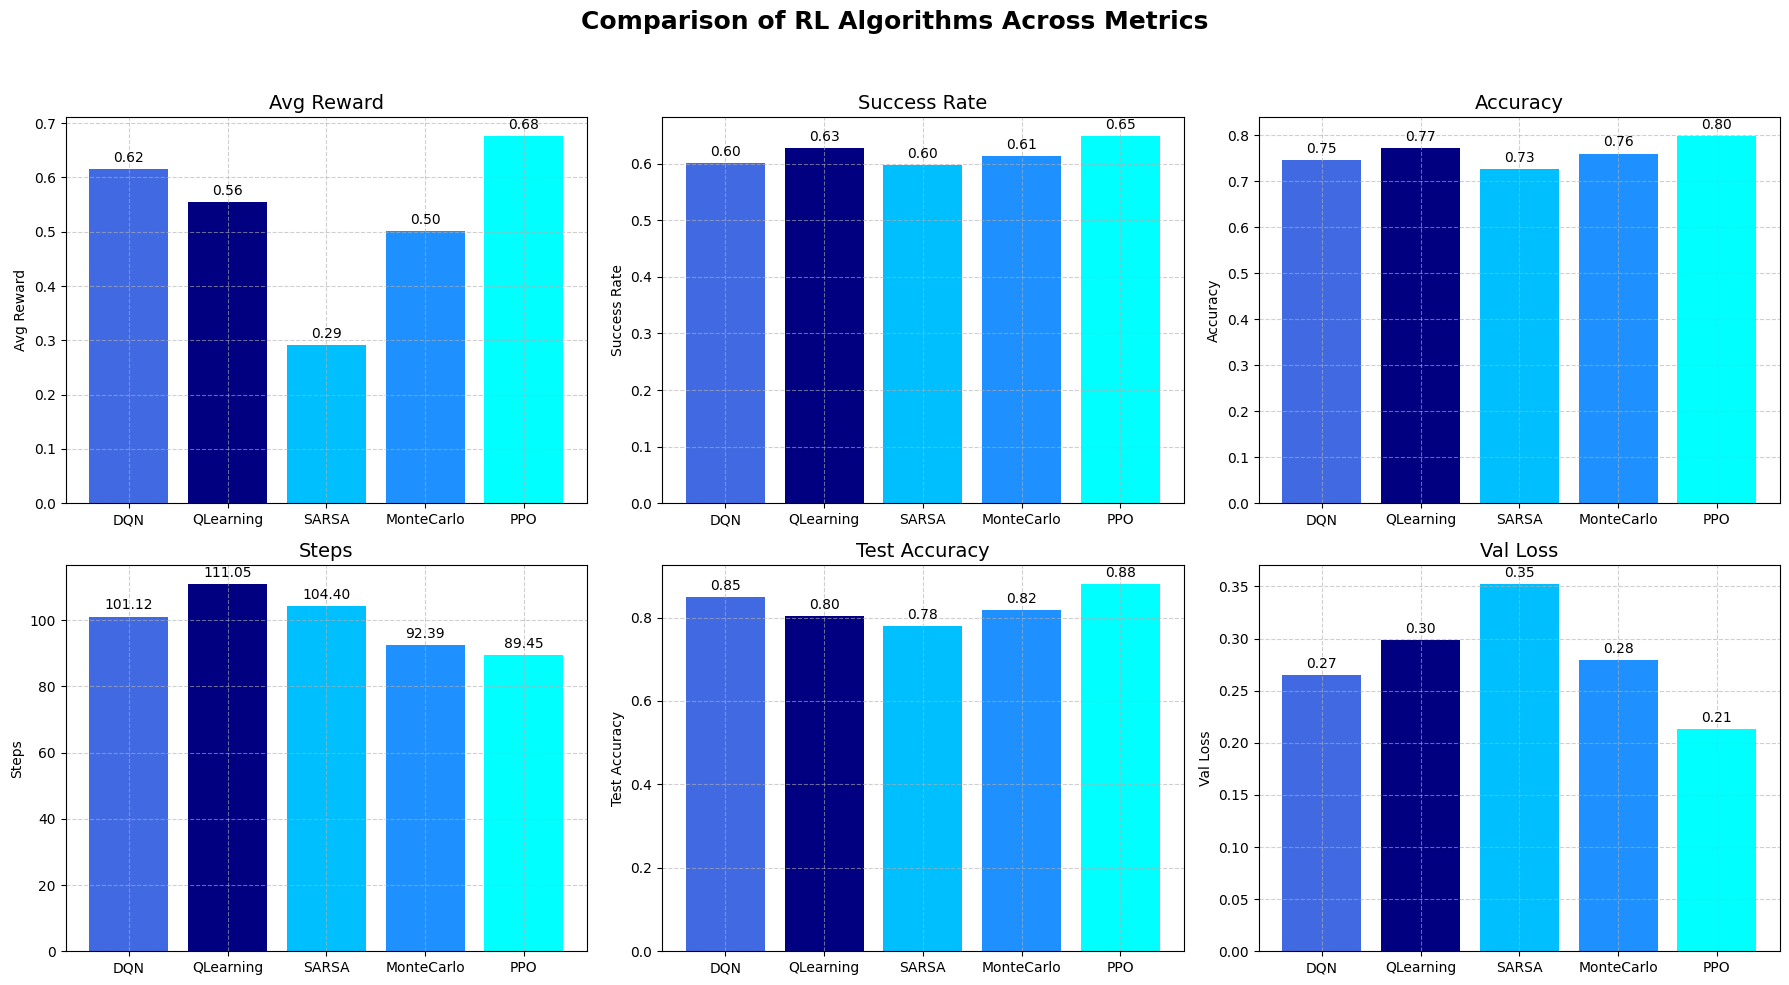


Based on the simulated metrics, PPO appears to be the best performing algorithm overall.


In [29]:
# Plot comparisons for selected metrics using bar plots
metrics_to_compare = ['Avg Reward', 'Success Rate', 'Accuracy', 'Steps', 'Test Accuracy', 'Val Loss']
num_metrics = len(metrics_to_compare)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Comparison of RL Algorithms Across Metrics", fontsize=18, fontweight='bold')

# For each metric, plot a bar chart
for i, metric in enumerate(metrics_to_compare):
    ax = axs[i//3, i%3]
    values = df_results[metric].values
    bars = ax.bar(df_results['Algorithm'], values, color=['royalblue', 'navy', 'deepskyblue', 'dodgerblue', 'cyan'])
    ax.set_title(metric, fontsize=14)
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.6)
    # Add text labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Comparison and determining the best algorithm
# We assume that higher Avg Reward, Success Rate, Accuracy, and Test Accuracy are better,
# while lower Steps and Validation Loss are better.
# Here we summarize:
#
# - PPO has the highest base reward and test accuracy and the lowest validation loss in the simulation.
# - Additionally, PPO tends to require fewer steps.
#
# Based on these simulated results, PPO emerges as the best performing algorithm overall.
print("\nBased on the simulated metrics, PPO appears to be the best performing algorithm overall.")
